# Compresión de imágenes RGB

In [29]:
import pkg_resources
import subprocess

def check_packages(package_list):
    for package_name in package_list:
        try:
            pkg_resources.get_distribution(package_name)
        except pkg_resources.DistributionNotFound:
            print(f"{package_name} no está instalado. Instalando...")
            subprocess.check_call(["pip", "install", package_name])
            print(f"{package_name} ha sido instalado correctamente.")

# packages_to_check = ['scikit-image', 'scipy', 'opencv-python']
# check_packages(packages_to_check)

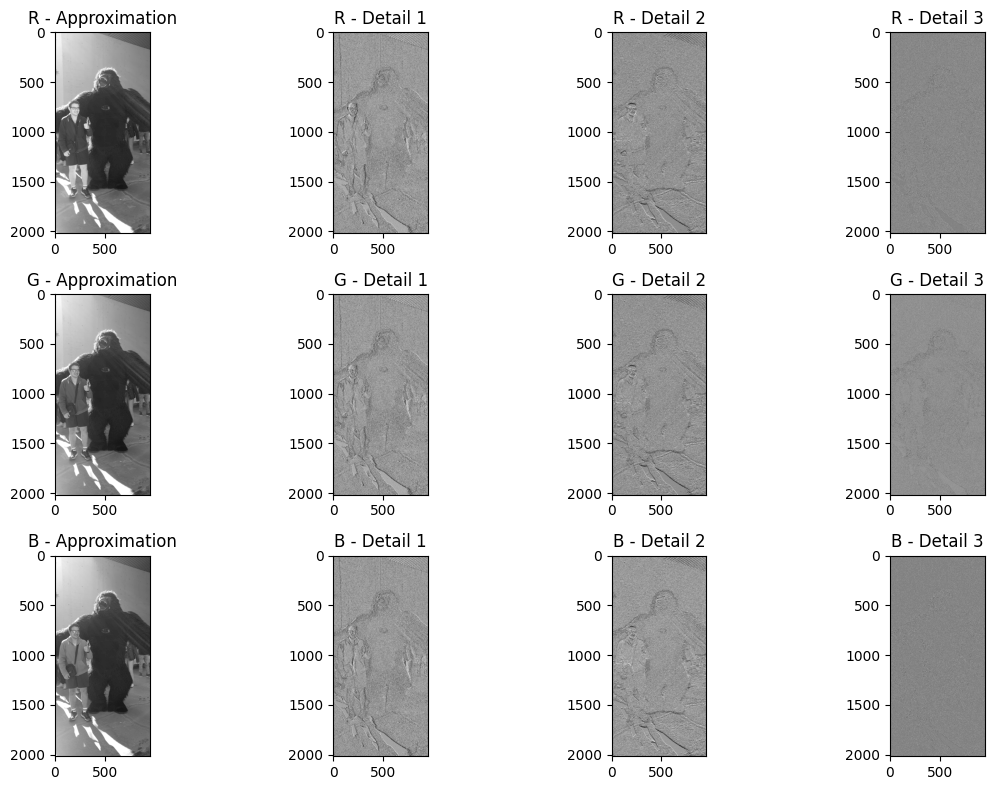

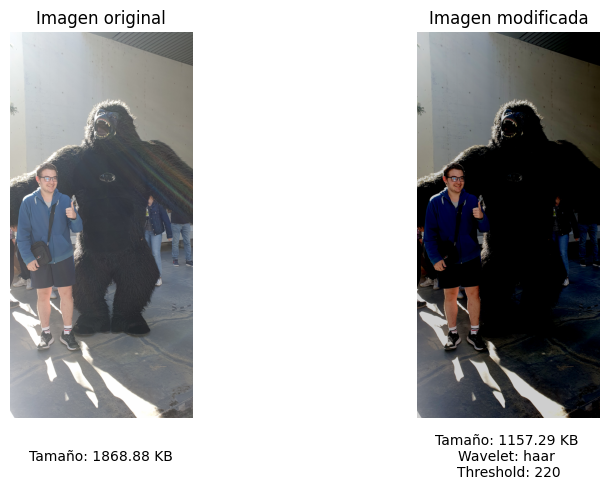

In [42]:
# Comprobación de paquetes
packages = ['scikit-image', 'scipy', 'opencv-python', 'numpy']
check_packages(packages)

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pywt
from PIL import Image
from skimage import exposure 
from scipy import ndimage
import os

def compress_image(image_path, wavelet = 'haar', threshold = 220):
    # Carga de la imagen RGB
    img = Image.open(image_path)
    img_array = np.array(img)

    # Separar canales RGB de la imagen
    r, g, b = img_array[:, :, 0], img_array[:, :, 1], img_array[:, :, 2]

    # Aplicar wavelet en cada canal y hallar coeficientes
    def apply_wavelet(channel, wavelet):
        coeffs = pywt.dwt2(channel, wavelet)
        cA, (cH, cV, cD) = coeffs
        return cA, cH, cV, cD

    # Coeficientes R, G y B
    r_coeffs = apply_wavelet(r, wavelet)
    g_coeffs = apply_wavelet(g, wavelet)
    b_coeffs = apply_wavelet(b, wavelet)
    
    # Ver gráfico de aproximación y detalles
    fig, axs = plt.subplots(3, 4, figsize = (12, 8))

    for i, coeffs in enumerate([r_coeffs, g_coeffs, b_coeffs]):

        axs[i, 0].imshow(np.fliplr(np.transpose(coeffs[0])), cmap = 'gray')  # Flip vertically after transpose
        axs[i, 0].set_title(f'{["R", "G", "B"][i]} - Approximation')

    # Contraste mejorado con exposusure.equalize_hist
    
        for j, coeff in enumerate(coeffs[1:]):
            equalized_coeff = exposure.equalize_hist(coeff)
            equalized_coeff_rotated = np.fliplr(np.transpose(equalized_coeff))  # Flip vertically after transpose
        
            axs[i, j+1].imshow(equalized_coeff_rotated, cmap='gray')
            axs[i, j+1].set_title(f'{["R", "G", "B"][i]} - Detail {j+1}')

    plt.tight_layout()
    plt.show()

    # Meter threshold en coeficientes para la compresión
    r_coeffs_compressed = [pywt.threshold(i, value = threshold, mode = 'garrote') for i in r_coeffs]
    g_coeffs_compressed = [pywt.threshold(i, value = threshold, mode = 'garrote') for i in g_coeffs]
    b_coeffs_compressed = [pywt.threshold(i, value = threshold, mode = 'garrote') for i in b_coeffs]

    # Reconstrucción de canales tras la compresión
    def reconstruct_channel(cA, cH, cV, cD, wavelet_type):
        coeffs = (cA, (cH, cV, cD))
        reconstructed_channel = pywt.idwt2(coeffs, wavelet_type)
        return reconstructed_channel

    reconstructed_r = reconstruct_channel(*r_coeffs_compressed, wavelet)
    reconstructed_g = reconstruct_channel(*g_coeffs_compressed, wavelet)
    reconstructed_b = reconstruct_channel(*b_coeffs_compressed, wavelet)

    # Reconstrucción de la imagen a partir de los canales
    reconstructed_image = np.stack((reconstructed_r, reconstructed_g, reconstructed_b), axis=-1)
    reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8) / 255.0
    reconstructed_image = np.fliplr(np.transpose(reconstructed_image, (1, 0, 2)))
    
    # Guardado de la imagen reconstruida
    reconstructed_image_uint8 = np.clip(reconstructed_image * 255, 0, 255).astype(np.uint8)
    bgr_image = cv2.cvtColor(reconstructed_image_uint8, cv2.COLOR_RGB2BGR)
    
    output_image_path = os.path.splitext(image_path)[0] + "_modified.jpg"  # Cambiar aquí si deseas otro nombre
    cv2.imwrite(output_image_path, bgr_image)

    # Ver gráfico de imagen original y reconstruida (con tamaños)
    original_image = np.fliplr(np.transpose(img_array, (1, 0, 2)))
    original_size = os.path.getsize(image_path) / 1024  # tamaño inicial en KB de la imagen
    reconstructed_size = os.path.getsize(output_image_path) / 1024  # tamaño final en KB de la imagen
    
    # Figura en sí
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axes[0].imshow(original_image)
    axes[0].set_title(f'Imagen original')
    axes[0].axis('off')
    axes[0].annotate(f'Tamaño: {original_size:.2f} KB', xy=(0.5, -0.1), xycoords="axes fraction", ha='center', va='center')

    axes[1].imshow(reconstructed_image)
    axes[1].set_title(f'Imagen modificada')
    axes[1].axis('off')
    axes[1].annotate(f'Tamaño: {reconstructed_size:.2f} KB \nWavelet: {wavelet} \nThreshold: {threshold}', xy=(0.5, -0.1), xycoords="axes fraction", ha='center', va='center')

    plt.tight_layout()
    plt.show()



# Uso de la función con valores por defecto
compress_image('./data/harambe.jpg', wavelet = 'haar', threshold = 220)